In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
import lseg.data as ld
ld.open_session()


<lseg.data.session.Definition object at 0x7f577413c4f0 {name='codebook'}>

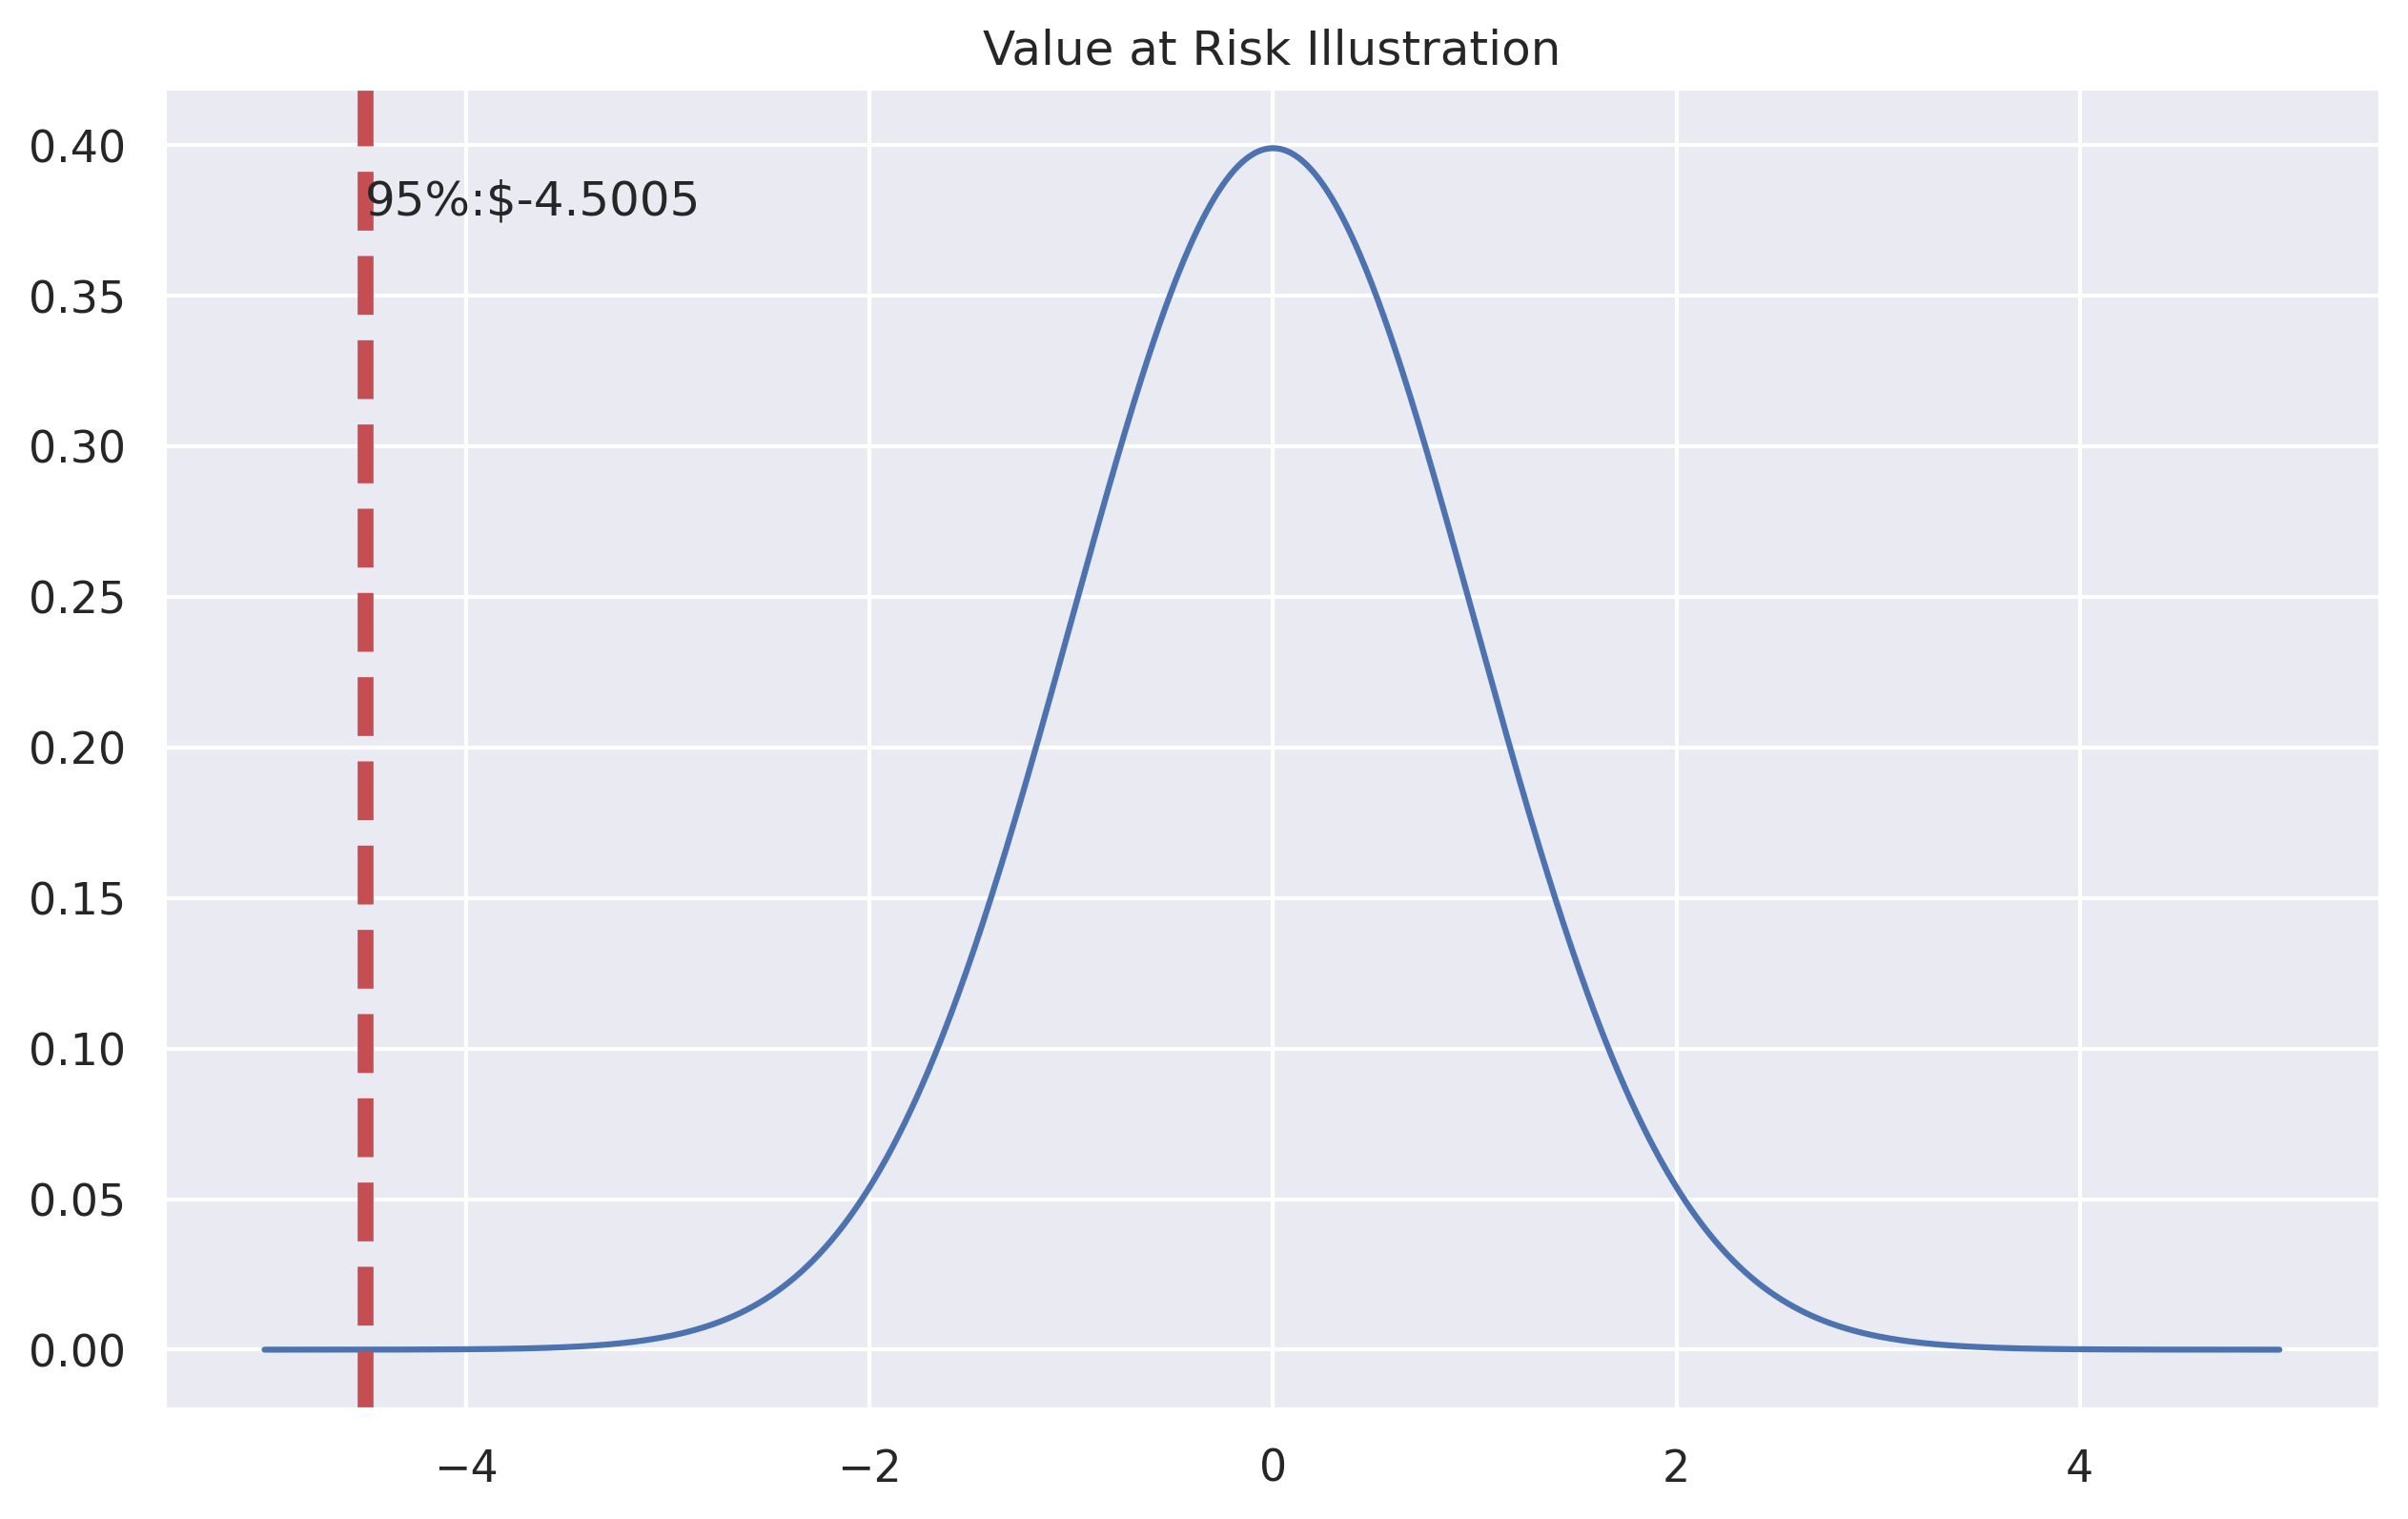

In [4]:
mean = 0
std_dev = 1
x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std_dev)
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
            linewidth=4)
plt.title('Value at Risk Illustration')
plt.show()

In [10]:
RICS = ["TSLA.N", "MSFT.O", "NVDA.O"]
ts = ld.get_data(RICS,
                   [
                    'TR.PriceClose(SDate=2021-01-02,EDate=2025-10-01,Frq=D).date',
                    'TR.PriceClose(SDate=2021-01-02,EDate=2025-01-01,Frq=D)'
                   ])
ts2 = ts.drop_duplicates()
ts2

,Instrument,Date,Price Close
0,TSLA.N,2021-01-04,243.29309
1,TSLA.N,2021-01-05,245.036422
2,TSLA.N,2021-01-06,252.063081
3,TSLA.N,2021-01-07,272.039728
4,TSLA.N,2021-01-08,293.379707
...,...,...,...
3570,NVDA.O,2025-09-24,<NA>
3571,NVDA.O,2025-09-25,<NA>
3572,NVDA.O,2025-09-26,<NA>
3573,NVDA.O,2025-09-29,<NA>


In [12]:
stocks = ts2.pivot(index="Date", columns="Instrument", values="Price Close")
stocks

Instrument,MSFT.O,NVDA.O,TSLA.N
Date,,,
2021-01-04,217.69,13.1135,243.29309
2021-01-05,217.9,13.40475,245.036422
2021-01-06,212.25,12.6145,252.063081
2021-01-07,218.29,13.344,272.039728
2021-01-08,219.62,13.27675,293.379707
...,...,...,...
2025-09-25,<NA>,<NA>,<NA>
2025-09-26,<NA>,<NA>,<NA>
2025-09-29,<NA>,<NA>,<NA>


In [13]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

Instrument,MSFT.O,NVDA.O,TSLA.N
Date,,,
2021-01-05,0.000964,0.021967,0.00714
2021-01-06,-0.026271,-0.060762,0.028273
2021-01-07,0.02806,0.05622,0.076269
2021-01-08,0.006074,-0.005052,0.07552
2021-01-11,-0.009746,0.025635,-0.082121
...,...,...,...
2024-12-24,0.00933,0.00393,0.070098
2024-12-26,-0.002781,-0.00207,-0.017983
2024-12-27,-0.017453,-0.021088,-0.050655


In [14]:
stocks_returns_mean = stocks_returns.mean()
weights  = np.random.random(len(stocks_returns.columns))
weights /= np.sum(weights)
#weights =  np.array([.333, .333, .333], dtype='float')
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [15]:
weights

array([0.14965318, 0.55682844, 0.29351838])

In [16]:
stocks_returns_mean

Instrument
MSFT.O    0.000658
NVDA.O    0.002317
TSLA.N    0.000504
dtype: Float64

In [17]:
print(stocks_returns_mean)
print(weights)
print(cov_var)
print(port_std) 

Instrument
MSFT.O    0.000658
NVDA.O    0.002317
TSLA.N    0.000504
dtype: Float64
[0.14965318 0.55682844 0.29351838]
Instrument    MSFT.O    NVDA.O    TSLA.N
Instrument                              
MSFT.O      0.000270  0.000343  0.000258
NVDA.O      0.000343  0.001087  0.000574
TSLA.N      0.000258  0.000574  0.001430
0.027087063250868126


In [18]:
weights = np.array([.2,.3,.4])

In [19]:
stocks_returns_mean = stocks_returns.mean()
stocks_returns_mean

Instrument
MSFT.O    0.000658
NVDA.O    0.002317
TSLA.N    0.000504
dtype: Float64

In [20]:
initial_investment = 1000000
conf_level = 0.95

In [21]:
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [22]:
port_std

0.02361421880986053

In [23]:
alpha = norm.ppf(.05, stocks_returns_mean, port_std)

In [24]:
alpha

array([-0.03818382, -0.03652484, -0.03833769])

In [25]:
stocks.columns

Index(['MSFT.O', 'NVDA.O', 'TSLA.N'], dtype='string', name='Instrument')

## Variance-Covariance Method

In [26]:
for i, j in zip(stocks.columns, range(len(stocks.columns))):
    VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
    print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))

Parametric VaR result for MSFT.O is 38183.81817313132 
Parametric VaR result for NVDA.O is 36524.84241452394 
Parametric VaR result for TSLA.N is 38337.69387216761 


In [27]:
def VaR_parametric(initial_investment, conf_level):
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
        print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_param

In [28]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param

Parametric VaR result for MSFT.O is 38183.81817313132 
Parametric VaR result for NVDA.O is 36524.84241452394 
Parametric VaR result for TSLA.N is 38337.69387216761 
--------------------------------------------------


array([38183.81817313, 36524.84241452, 38337.69387217])

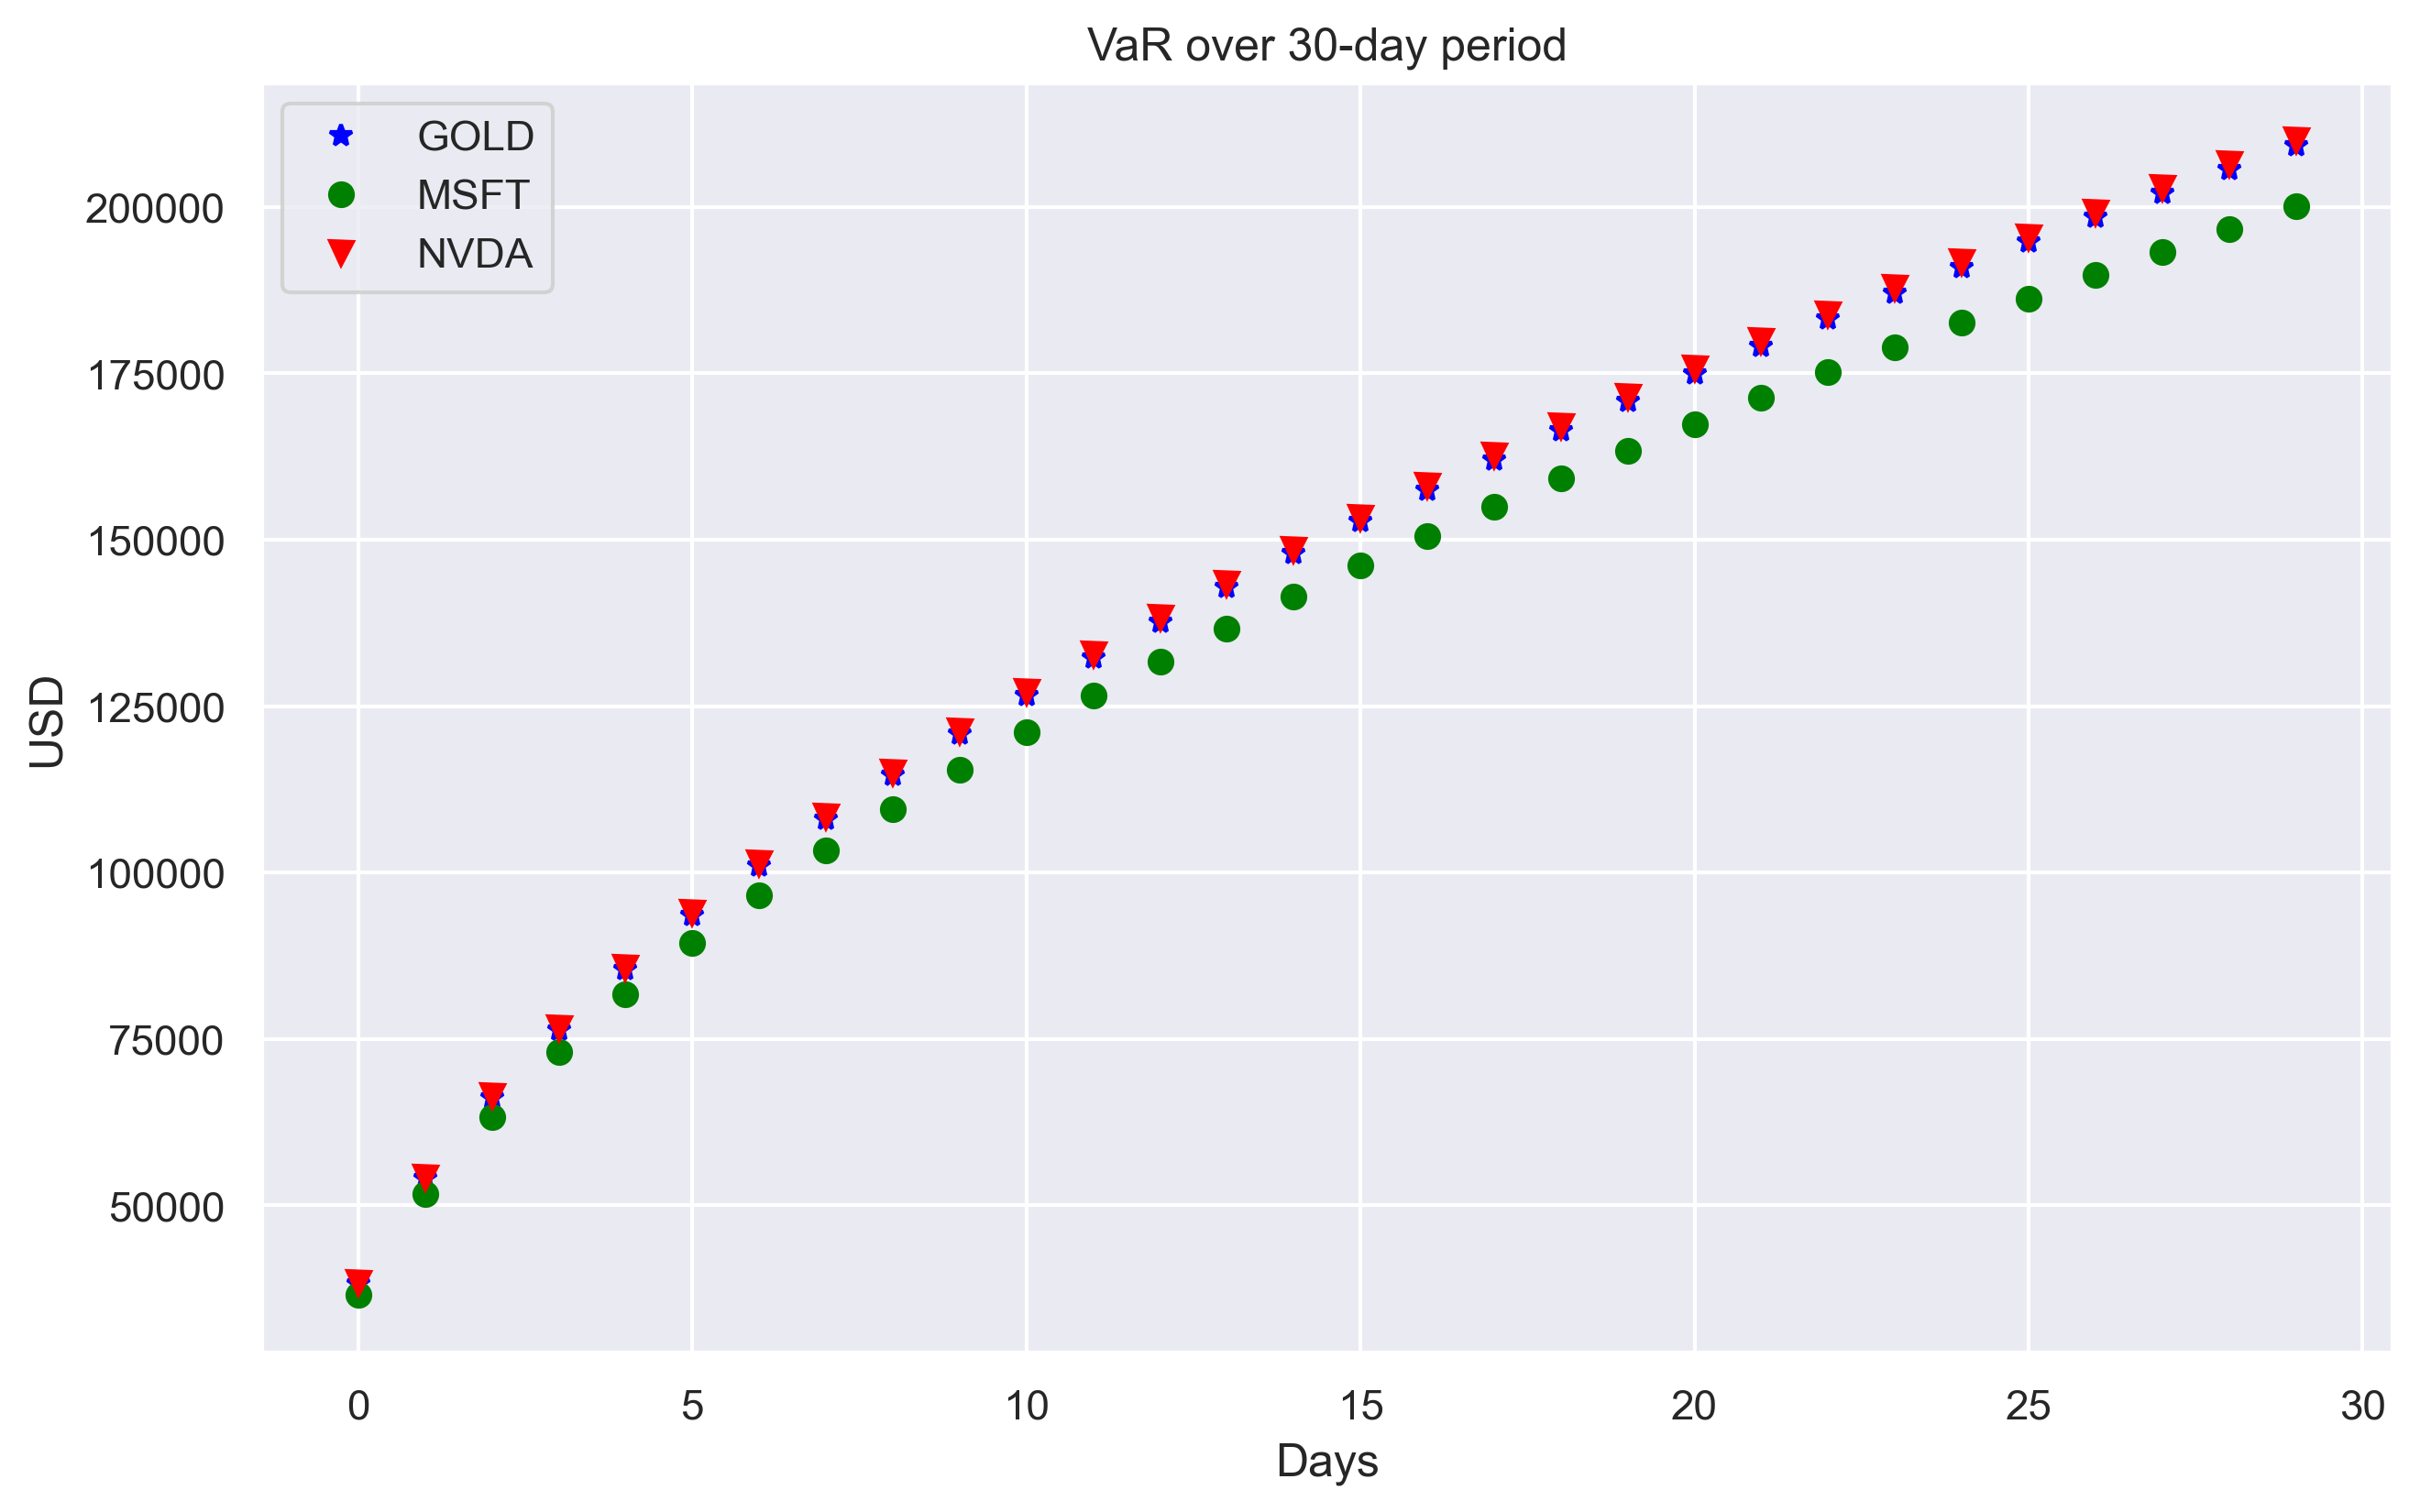

In [29]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='GOLD')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='NVDA')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")
plt.legend()
plt.show()

## Historical


In [30]:
for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
    print(np.percentile(stocks_returns.loc[:, i], 5))

-0.02712200572752379
-0.049828831937088286
-0.06286050217304967


In [31]:
stocks_returns.loc[:, 'NVDA.O']

Date
2021-01-05    0.021967
2021-01-06   -0.060762
2021-01-07     0.05622
2021-01-08   -0.005052
2021-01-11    0.025635
                ...   
2024-12-24     0.00393
2024-12-26    -0.00207
2024-12-27   -0.021088
2024-12-30    0.003497
2024-12-31    -0.02355
Name: NVDA.O, Length: 1004, dtype: Float64

In [32]:
np.percentile(stocks_returns.loc[:, 'NVDA.O'], 5)

-0.049828831937088286

In [33]:
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns.loc[:, i],
                                               5))
        print("Based on historical values 95% of {}'s return is {:.4f}"
              .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                          (1 + Hist_percentile95[j]))
        print("Historical VaR result for {} is {:.2f} "
              .format(i, VaR_historical))
        print('--' * 35)

In [34]:
VaR_historical(initial_investment,conf_level)

Based on historical values 95% of MSFT.O's return is -0.0271
Historical VaR result for MSFT.O is 27122.01 
----------------------------------------------------------------------
Based on historical values 95% of NVDA.O's return is -0.0498
Historical VaR result for NVDA.O is 49828.83 
----------------------------------------------------------------------
Based on historical values 95% of TSLA.N's return is -0.0629
Historical VaR result for TSLA.N is 62860.50 
----------------------------------------------------------------------


## Monte Carlo VaR

In [35]:
x = np.random.uniform(-1, 1, 100) 
y = np.random.uniform(-1, 1, 100)

In [36]:
y

array([ 0.19147989, -0.23044328, -0.81379685, -0.53994334,  0.46459675,
        0.41139644,  0.48676954,  0.57514947, -0.27542755,  0.14406302,
        0.5930476 , -0.67889034, -0.2070221 , -0.0246357 , -0.06574233,
       -0.32204705,  0.68383659,  0.73077146,  0.6735081 , -0.91226374,
        0.82774521,  0.18592202, -0.51378916, -0.9129693 ,  0.62022796,
       -0.32430913,  0.77130582,  0.84407567, -0.43757837,  0.5965815 ,
        0.15552371,  0.61556805,  0.28839091, -0.49790846, -0.46992161,
       -0.30444417, -0.1031738 , -0.492892  ,  0.77106431, -0.04412876,
       -0.26041027, -0.14809655, -0.78095114, -0.59970583,  0.71457808,
       -0.76012227,  0.16435681,  0.70903684, -0.53391238,  0.36826473,
       -0.15996071, -0.59547767,  0.04592598,  0.29473213,  0.78136331,
        0.42325985,  0.6125174 ,  0.30558413, -0.74973504, -0.69260252,
       -0.35314363, -0.79124403, -0.41591202,  0.88661242, -0.18369256,
        0.05398737, -0.72458952, -0.53203986, -0.67807367,  0.51

In [37]:
x

array([-0.57600554, -0.39730454, -0.8665671 ,  0.65407526,  0.47632164,
       -0.92674295,  0.51397917,  0.72508964, -0.96372575, -0.47261338,
        0.74618053,  0.61397911, -0.54119913, -0.53108806,  0.76667727,
        0.20707102,  0.7175919 , -0.18544795, -0.48557458, -0.02413077,
        0.34344968, -0.82181476,  0.04900106, -0.37858881, -0.83781431,
       -0.37967211, -0.29903227, -0.93019347, -0.47777761, -0.62031355,
       -0.97905003,  0.79893883,  0.5753015 ,  0.21525105, -0.97612395,
        0.44929137,  0.05485567, -0.73367095,  0.37101431,  0.67390759,
       -0.55818845, -0.0432643 , -0.42177037,  0.00294739, -0.69451851,
        0.18626816, -0.21188935, -0.28539259, -0.00660216, -0.2341535 ,
        0.23827276, -0.00614387, -0.0372912 ,  0.45900216,  0.5499977 ,
       -0.13285486, -0.80965983, -0.69740947,  0.79825734,  0.16116282,
        0.16797098, -0.15791965,  0.80035392,  0.6054242 , -0.86428901,
        0.55593449,  0.93018129, -0.47064892, -0.41683228, -0.50

In [38]:
sample = 100    
def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) <= 1:
            point_inside_circle += 1 
    print('pi value is {}'.format(4 * point_inside_circle/sample))

In [39]:
pi_calc(x,y)

pi value is 3.4


In [40]:
len(stocks.columns)

3

In [41]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    print(i)

0
1
2


In [42]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    mean = np.random.randn(n).mean()
    std = np.random.randn(n).std()
    temp = pd.DataFrame(np.random.normal(mean, std, num_reps))
    sim_data = pd.concat([sim_data, temp], axis=1)
sim_data.columns = ['Simulation 1', 'Simulation 2', 'Simulation 3']

In [43]:
sim_data

,Simulation 1,Simulation 2,Simulation 3
0,0.126414,-0.482009,0.020171
1,-0.927786,0.921272,-1.167817
2,0.661086,-0.019520,0.227435
3,-0.054938,0.331703,-1.261611
4,-0.324405,-0.233105,-0.315959
...,...,...,...
995,1.164828,0.950558,-0.165710
996,0.538210,0.523509,-0.242388
997,1.286087,-0.951404,1.298822
998,1.068715,-0.605927,0.133832


In [44]:
MC_percentile95 = []
for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
    print(i,j)

Simulation 1 0
Simulation 2 1
Simulation 3 2


In [45]:
def MC_VaR(initial_investment, conf_level):
    MC_percentile95 = []
    for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
        MC_percentile95.append(np.percentile(sim_data.loc[:, i], 5))
        print("Based on simulation 95% of {}'s return is {:.4f}"
              .format(i, MC_percentile95[j]))
        VaR_MC = (initial_investment - initial_investment * 
                  (1 + MC_percentile95[j]))
        print("Simulation VaR result for {} is {:.2f} "
              .format(i, VaR_MC))
        print('--' * 35)

In [46]:
MC_VaR(initial_investment, conf_level)

Based on simulation 95% of Simulation 1's return is -1.8267
Simulation VaR result for Simulation 1 is 1826708.13 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 2's return is -1.5187
Simulation VaR result for Simulation 2 is 1518717.81 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 3's return is -1.6607
Simulation VaR result for Simulation 3 is 1660667.63 
----------------------------------------------------------------------
